In [ ]:
#%%writefile "/home/mohamm/Downloads/test.ipynb"

import numpy as np
import scipy as sp
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pathlib import Path
from typing import List, Iterable, Optional, Dict, Union
import h5py
from pandas import Series, DataFrame
import glob
from scipy.interpolate import make_interp_spline
import flashdaqhdfutils as fdu
from skimage.measure import block_reduce
import os
import scipy.signal

# assert sys.version_info >= (3, 8), f"Requires at least Python version 3.8, but was {sys.version}"

# Set parameters
e_mass = 0.51*1e6 #electron mass in [eV/c^2] unit 
step_size_no = 0.03
#fel_ev = 36.5 #different for each beamtime/measurement
fel_ev = 95.4 #for 1 Sep beamtime 
e_binding_energy = 21.6 #different for each gas - this value if for Ne
w_0 = fel_ev - e_binding_energy #photoelectron Energy! .. varies for different runs
print(w_0)

new_size = 10
max_length = 4550

In [14]:
def dset_data_frame(group: h5py.Group, alias: Optional[str] = None) -> DataFrame:
    """Returns a pandas DataFrame for the given HDF group"""
    if not alias:
        alias = "/".join(group.name.split("/")[-3:])
    train_id = Series(group["index"], name="Train ID")
    return Series((group["value"][i] for i in train_id.index), name=alias, index=train_id).to_frame()


# the function below converts time of flight to energy (not sure about it)
def time2energy_conversion(parameters_calibration, sample_rate_value, sample_min, sample_max):
    """time axis in nanoseconds"""
    tof_axis = np.linspace(sample_min, sample_max, sample_max-sample_min)*sample_rate_value
    l_eff_2 = parameters_calibration[0]
    time_zero = parameters_calibration[1]
    constant = parameters_calibration[2]

    def time2energy_function(time_axis, *q):
        l_eff_squared, t_0, cte = q
        return (l_eff_squared / (time_axis + t_0) ** 2) #+ cte

    energy_calibration = time2energy_function(tof_axis, *[l_eff_2, time_zero, constant])
    # idx_energy = np.argmax(energy_calibration)
    # print('MAX MIN VALUES::', np.shape(energy_calibration[idx_energy:]), np.nanmax(energy_calibration), np.nanmin(energy_calibration))
    return energy_calibration


def normalize_matrix(matrix):
    normalized_matrix = np.zeros((len(matrix[:, 0]), len(matrix[0, :])))
    for i in range(len(matrix[0, :])):
        normalized_matrix[:, i] = matrix[:, i]/np.nanmax(matrix[:, i])

    return normalized_matrix

# this function provides the average of streaking trace + downsized time vector
def scan_average_over_step_size(step_size, time_delay, energy_axis_ev, adc_matrix):
    time_axis = np.arange(np.nanmin(time_delay), np.nanmax(time_delay), step_size)
    adc_data_timescale = np.zeros((len(energy_axis_ev), len(time_axis)))
    norm_adc_matrix = normalize_matrix(adc_matrix)
    print(np.shape(adc_data_timescale), np.shape(adc_matrix), len(energy_axis_ev), len(time_axis))
    for i in range(len(time_axis)):
        index_time = np.where(np.abs(time_delay - time_axis[i]) <= step_size)[0][:]
        adc_data_timescale[:, i] = np.nanmean(norm_adc_matrix[:, index_time], axis=1)
        # adc_data_timescale[:, i] = np.nanmean(adc_matrix[:, index_time], axis=1)

    return adc_data_timescale, time_axis


# Finding max value of Pulse
def get_pulses_peak_energy_value(delay_time_axis, energy_array, Spectogram_matrix):
    idx_max_value_energy = np.zeros(len(delay_time_axis))
    max_values_energy = np.zeros(len(delay_time_axis))
    for i in range(len(Spectogram_matrix[0, :])):
        idx_max_value_energy[i] = Spectogram_matrix[:, i].tolist().index(np.nanmax(Spectogram_matrix[:, i], axis=0))
        max_values_energy[i] = energy_array[int(idx_max_value_energy[i])]
    return max_values_energy


# the function below calculates the vector potential from the energy
def streaking_to_vector_potential_units(streaking_trace_ev, com_energy):
    streaking_shift = (np.max(streaking_trace_ev) - np.min(streaking_trace_ev))/2
    print('shift',streaking_shift )
    A_streak_max = np.sqrt(e_mass) * streaking_shift / (3E8*np.sqrt(2 * com_energy))
    print('Amax::', A_streak_max)
    A_thz_Vpers_m = (A_streak_max * (streaking_trace_ev-np.nanmin(streaking_trace_ev))/(np.max(streaking_trace_ev)-np.nanmin(streaking_trace_ev)))#+com_energy
    print('V potential::', np.nanmax(A_thz_Vpers_m), np.nanmin(A_thz_Vpers_m), np.nanmax(A_thz_Vpers_m)-np.nanmin(A_thz_Vpers_m))
    return A_thz_Vpers_m


def derivative_of_array(array_to_derive, dx):
    derivative = np.diff(array_to_derive) / np.diff(dx)
    return derivative


def remove_bckg(data_matrix):
    background = 30
    data_matrix_no_background = np.zeros((len(data_matrix[:, 0]), len(data_matrix[0, :])))
    for i in range(len(data_matrix[0, :])):
        background_value = np.nanmean(np.absolute(data_matrix[0:background, i]), axis=0)
        data_matrix_no_background[:, i] = data_matrix[:, i] + background_value

    return data_matrix_no_background


def data2matrixarray(data_frame_pds, sample_no_min, sample_no_max):
    new_matrix = np.zeros((len(data_frame_pds), sample_no_max-sample_no_min))
    for i in range(len(data_frame_pds)):
        new_matrix[i, :] = data_frame_pds[i, 0][sample_no_min:sample_no_max]
    return new_matrix

def sloper(delaypoint,x,y,thickness):   
    for i in range(0,len(x)):
        if delaypoint > x[i]:
            pass
        else: 
            break 
    slope=(y[i+thickness]-y[i-thickness])/(x[i+thickness]-x[i-thickness])
    point_x = [x[i-thickness], x[i+thickness]]
    point_y = [y[i-thickness], y[i+thickness]]
    return point_x,point_y,slope

    
    
def scanner(adc_data,laser_delay_data,retardation_voltage_data,sample_frequency_data,tofnumber, sample_min, sample_max):
    
    
    adc_matrix_data = adc_data.to_numpy() #TOF data
    adc_spectrum = -np.transpose(data2matrixarray(adc_matrix_data, sample_min, sample_max)) # [shot#, sample#]
    laser_delay = laser_delay_data.to_numpy()[:, 0]
    retardation_voltage = float(retardation_voltage_data.to_numpy()[100, 0])
    sample_frequency = float(sample_frequency_data.to_numpy()[20, 0])

    #energy_calibration_parameters=([ 445703.27386753, -980.5518246512398,  -4.325108030862267]) #data used in the online analysis, it's not correct
    energy_calibration_parameters=([ 1.99774128e+05, -9.98000000e+02,  4.50000000e+01])
    #energy_calibration_parameters = np.genfromtxt('/home/mohamm/Downloads/time2energy_function_parameters.csv')


    sample_rate = 1E3/sample_frequency   # Frequency in GIGAHERTZ ----> nanoseconds
    adc_no_bck = remove_bckg(adc_spectrum[:, :])
    time_delay_axis = np.linspace(np.nanmin(laser_delay), np.nanmax(laser_delay), len(adc_no_bck[0, :])) #- BAM_time
    
    extra = tofnumber

    energy_axis = time2energy_conversion(energy_calibration_parameters, sample_rate, sample_min, sample_max) + retardation_voltage # calculating energy axis
    adc_averaged = scan_average_over_step_size(step_size_no, time_delay_axis, energy_axis, adc_no_bck) # normalized and averaged spectrum
    
    scan_averaged = adc_averaged[0]
    time_averaged_step_size = adc_averaged[1]#[~idx_nans_scan_matrix[0, :]]
    

    idx_nans_scan_matrix = np.isnan(scan_averaged)
    scan_averaged_nonans = scan_averaged[~idx_nans_scan_matrix]
    scan_averaged_nonans = np.reshape(scan_averaged_nonans, (len(energy_axis),int(len(scan_averaged_nonans)/len(energy_axis))))

    Streaking_Trace_eV_step_size = get_pulses_peak_energy_value(time_averaged_step_size, energy_axis, scan_averaged_nonans)

    smoothed_Streaking_Trace_eV_step_size = savgol_filter(Streaking_Trace_eV_step_size, 15, 3)
    vector_potential = streaking_to_vector_potential_units(smoothed_Streaking_Trace_eV_step_size, w_0) # converting the streaking trace into vector potential function

    electric_field = np.gradient(vector_potential, time_averaged_step_size*1E-12) # calculating the electric field from the vector potential
    smoothed_electric_field = savgol_filter(electric_field, 15, 3)
    electric_field_kv_cm = smoothed_electric_field*1e-5
    spectrum = np.fft.fft(electric_field_kv_cm)
    frequency = np.fft.fftfreq(electric_field_kv_cm.size, np.nanmean(np.diff(time_averaged_step_size)))
    
    
    #np.savetxt(path+'processed'+'/data/'+run_number+extra+'scan_averaged'+'.csv', scan_averaged)
    #np.savetxt(path+'processed'+'/data/'+run_number+extra+'delay_ps_axis'+'.csv', time_averaged_step_size)
    #np.savetxt(path+'processed'+'/data/'+run_number+extra+'energy_axis'+'.csv', energy_axis)


    return time_averaged_step_size, smoothed_Streaking_Trace_eV_step_size, electric_field_kv_cm, vector_potential, time_averaged_step_size, energy_axis, scan_averaged, adc_averaged, frequency,adc_no_bck


In [6]:
def get_path(run_number):
    path = '/asap3/flash/gpfs/fl21/2021/data/11012601/raw/hdf/Sept1/'
    file_num = 1
    filename = glob.glob(path+'FLASH2_USER1_stream_2_'+run_number+f'_file{file_num}_*.h5')[0]
    file_path = Path(filename)
    return file_path,filename,path,file_num

run_number = 'run40129'
file_path, filename, path, file_num=get_path(run_number)

with h5py.File(file_path, 'r') as h5_file:
    adc_data1 = dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH00/TD"])   #address of the adc (tof data)
    adc_data2 = dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH02/TD"])
    laser_delay_data = dset_data_frame(h5_file["FL2/Experiment/FL21/Laser/streaking delayline pos"])
    #retardation_voltage_data = dset_data_frame(h5_file["FL2/Experiment/FL21/TOF/retardation voltage readback 1"])
    retardation_voltage_data = dset_data_frame(h5_file["/uncategorised/FLASH.FEL/FL21.VACUUM/BEAMLINE/OPCUA.PRG_Beamline.fbTOF1.fRetVoltV"])
    sample_frequency_data1 = dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH00/sample frequency"])
    sample_frequency_data2 = dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH02/sample frequency"])
    raw_data = dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH00/TD"])
    #polarix_data = dset_data_frame(h5_file["/uncategorised/FLASH.DIAG/CAMERA/OTR9FL2XTDS"])

save_path = '/asap3/flash/gpfs/fl21/2021/data/11012601/processed/Analysis results/Scan runs/'
try:
    os.mkdir(save_path + run_number +f'_file{file_num}/')
except OSError:
    pass
os.makedirs(save_path + run_number +f'_file{file_num}/', exist_ok=True)

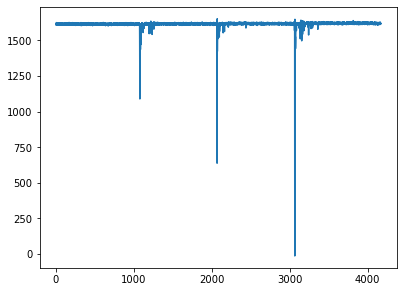

(500, 100) (500, 4550) 500 100
shift 16.275988925614065
Amax:: 3.18909928567159e-06
V potential:: 3.18909928567159e-06 0.0 3.18909928567159e-06


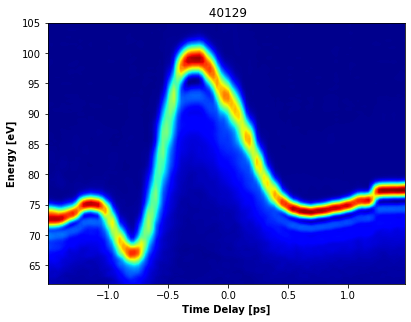

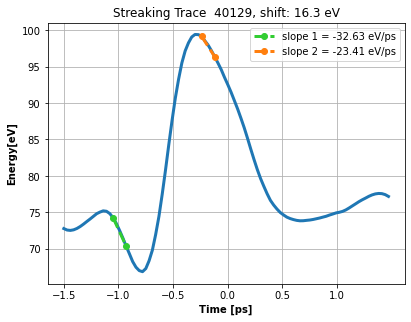

begining point for first slope: -1.0496800422668453 74.2781240891067
end point for first slope:      -0.9296800422668452 70.36276745447165
----
begining point for first slope: -0.23968004226684458 99.17332574099925
end point for first slope:      -0.11968004226684448 96.36464100083481


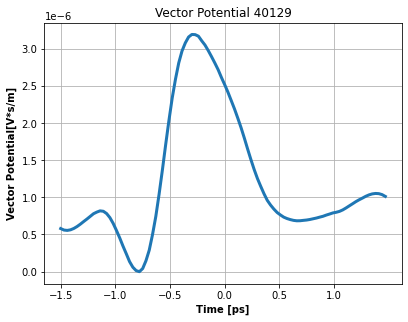

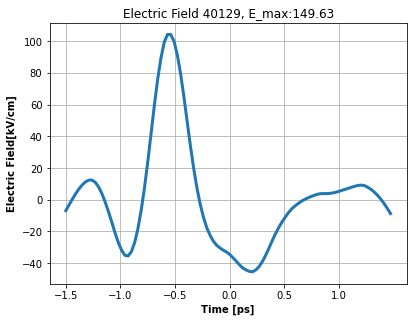

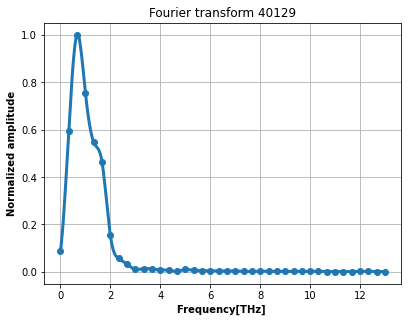

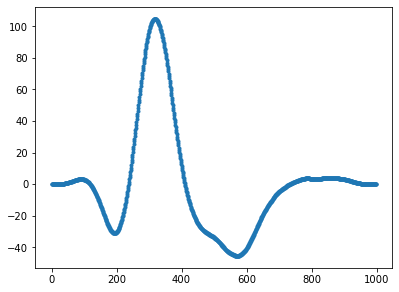

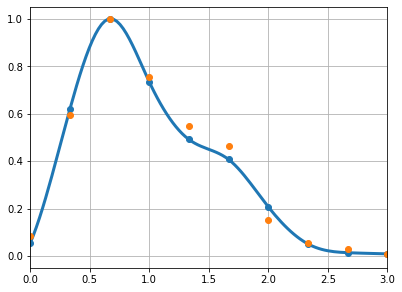

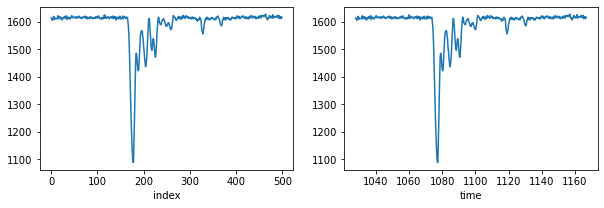

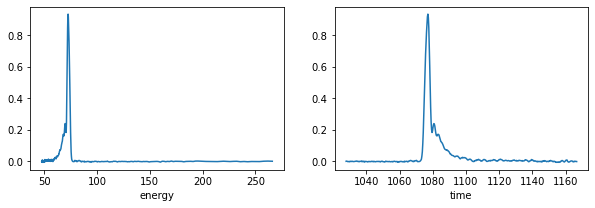

Text(0, 0.5, 'energy')

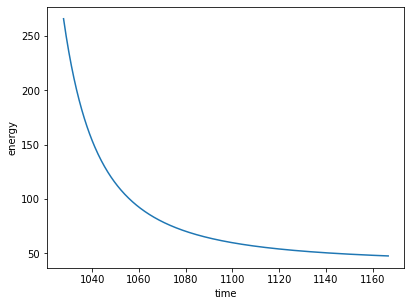

In [15]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


s_min = 0     # min sample number of the adc
s_max = 15000   # max sample number of the adc

sample_frequency = float(sample_frequency_data1.to_numpy()[20, 0])
sample_rate = 1E3/sample_frequency   # Frequency in GIGAHERTZ ----> nanoseconds
ttof_axis = np.linspace(s_min, s_max, s_max-s_min)*sample_rate

raw = raw_data.to_numpy()  # this line is to get the right range for the first FEL pulse
raww = data2matrixarray(raw, s_min, s_max)

plt.plot(ttof_axis,raww[0])
plt.show()

#polarx=data2matrixarray(polarix_data, s_min, s_max)


samplemin = 3700     # min sample number of the adc
samplemax = 4200     # max sample number of the adc
tof_axis = np.linspace(samplemin, samplemax, samplemax-samplemin)*sample_rate

time_tof1,str_trace_tof1,e_field, v_potential, time_averaged_step_size, energy_axis, scan_averaged, adc, frequency, adc_no_bck = scanner(adc_data1.iloc[0:max_length],laser_delay_data,retardation_voltage_data,sample_frequency_data1,'_tof1_', samplemin, samplemax)
#time_tof1,str_trace_tof1,e_field, v_potential, time_averaged_step_size, energy_axis, scan_averaged, adc, frequency, adc_no_bck = scanner(adc_data2,laser_delay_data,retardation_voltage_data,sample_frequency_data2,'_tof2_', samplemin, samplemax)

#wind = np.kaiser(len(e_field),0)
spectrum = np.fft.fft(e_field)
#spectrum = np.fft.fft(e_field[0:20])

# the line below generate more data points with interpolation for the E-field

new_length = 1000 # length of interpolated array
new_time = np.linspace(time_averaged_step_size[0:len(e_field)].min(), time_averaged_step_size[0:len(e_field)].max(), new_length)
new_field = sp.interpolate.interp1d(time_averaged_step_size[0:len(e_field)], e_field, kind='cubic')(new_time)

new_freq = np.linspace(frequency[:int(len(frequency)/2)].min(), frequency[:int(len(frequency)/2)].max(), new_length)
new_spec = sp.interpolate.interp1d(frequency[:int(len(frequency)/2)], spectrum[:int(len(frequency)/2)], kind='linear')(new_freq)


#spectrum_new = np.fft.fft(new_field)


raww = data2matrixarray(raw, samplemin, samplemax)

################################################################# first plot - str trace #################################################################

X, Y = np.meshgrid(time_averaged_step_size, energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
ax.set_xlabel('Time Delay [ps]', fontweight='bold')
ax.set_ylabel('Energy [eV]',fontweight='bold')
plt.title(' %s' % run_number)
ax.tick_params()
plt.ylim(62, 105)
#plt.xlim(1,1.5)
CS = ax.contourf(X, Y, scan_averaged, 500, cmap=plt.cm.jet) #vmax=700, vmin=-1800)
# l = ax.clabel(CS, colors="white", inline=True, fontsize="large", manual=True)
# plt.legend()
# plt.savefig(path_save+'/plots/'+run_number+'_scan_energy_delay_time'+auger+'.png')
# plt.savefig(path+'processed'+'/plots/'+run_number+extra+'scan_energy_delay_time'+'.png', dpi=600)
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'scan_energy_delay_time'+'.png', dpi=600)
#plt.savefig(f"{run_number}_trace.png")
plt.show()

################################################################# second plot - str trace + str slope #################################################################

plt.figure()  # shows maximum points in the streaking trace
plt.xlabel('Time [ps]', fontweight='bold')
plt.ylabel('Energy[eV]', fontweight='bold')
plt.title('Streaking Trace  %s, shift: %.1f eV' % (run_number, (np.nanmax(str_trace_tof1)-np.nanmin(str_trace_tof1))/2 ))

#plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 0.25))

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
plt.plot(time_averaged_step_size, str_trace_tof1,linewidth=3.0)
# plt.savefig(path+'processed'+'/plots/'+run_number+'_str_trace_ev'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'str_trace_ev'+'.png', dpi=600)

p1,p2,slope1 = sloper(-1.0,time_averaged_step_size, str_trace_tof1,2)
p3,p4,slope2 = sloper(-0.2,time_averaged_step_size, str_trace_tof1,2)

plt.plot(p1,p2,'o--',label=('slope 1 = %s eV/ps' % round((slope1),2)),linewidth=3.0,color='limegreen')
plt.plot(p3,p4,'o--',label=('slope 2 = %s eV/ps' % round((slope2),2)),linewidth=3.0)
plt.legend()
plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
#plt.savefig(f"{run_number}_trace_slope.png")
plt.show()
print('begining point for first slope:',p1[0],p2[0])
print('end point for first slope:     ',p1[1],p2[1])
print('----')
print('begining point for first slope:',p3[0],p4[0])
print('end point for first slope:     ',p3[1],p4[1])

################################################################# third plot - vector potential #################################################################

plt.figure()
plt.xlabel('Time [ps]', fontweight='bold')
plt.ylabel('Vector Potential[V*s/m]', fontweight='bold')
plt.title('Vector Potential %s' % run_number)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 1))
plt.plot(time_averaged_step_size, v_potential,linewidth=3.0)
# plt.savefig(path_save+'/plots/'+run_number+'_vector_potential_evsm'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'vector_potential_evsm'+'.png', dpi=600)

plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
#plt.savefig(f"{run_number}_vector_potential.png")
plt.show()

################################################################# fourth plot - E-field #################################################################

plt.figure()   # shows the calculated electric field of the THz pulse
plt.xlabel('Time [ps]',  fontweight='bold')
plt.ylabel('Electric Field[kV/cm]', fontweight='bold')
plt.title('Electric Field %s, E_max:%.2f' % (run_number, np.nanmax(e_field)-np.nanmin(e_field)))
plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 1))
plt.plot(time_averaged_step_size[0:len(e_field)], e_field,linewidth=3.0)
# plt.savefig(path_save+'/plots/'+run_number+'_electric_field_kvcm'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'electric_field_kvcm'+'.png', dpi=600)
plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
#plt.savefig(f"{run_number}_Efield.png")
plt.show()

################################################################# fifth plot - spectrum #################################################################

plt.figure()   # shows the spectrum of the THz pulse
plt.xlabel('Frequency[THz] ',fontweight='bold')
plt.ylabel('Normalized amplitude', fontweight='bold')
plt.title('Fourier transform %s' %(run_number))
# plt.xticks(np.arange(np.nanmin(time_averaged_step_size[0:len(spectrum)])-0.5, np.nanmax(time_averaged_step_size[0:len(spectrum)])+0.5, 1))
# plt.xlabel.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)), 'o',linewidth=5.0)

x = frequency[:int(len(frequency)/2.5)] # this line is to smoothen the curve
X_Y_Spline = make_interp_spline(frequency[:int(len(frequency)/2.5)],(np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)))
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

plt.plot(X_,Y_,'#1f77b4',linewidth=3.0)

# plt.savefig(path_save+'/plots/'+run_number+'_amplitude_thz'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'amplitude_thz'+'.png', dpi=600)
plt.grid()
#plt.savefig(f"{run_number}_spectrum.png")
plt.show()

################################################################# sixth plot - spectrum more points #################################################################

window = signal.windows.tukey(len(new_field))
#window = signal.windows.cosine(len(new_field))

plt.plot(window*new_field,'.')
plt.show()

l_pad = 200
#new_field = np.pad(new_field, (l_pad, l_pad), 'constant', constant_values=(0, 0)) #it does zero padding
#window = np.pad(window, (l_pad, l_pad), 'constant', constant_values=(0, 0))

spectrum_new = signal.detrend(np.fft.fft(window*new_field[0:int(len(new_field))]))  #I have to apply a window on the e field 
spectrum_new = spectrum_new - np.mean(spectrum_new)
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum_new)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum_new)), 'o',linewidth=5.0)

#x = frequency[:int(len(frequency)/2.5)] # this line is to smoothen the curve
new_Spline = make_interp_spline(frequency[:int(len(frequency)/2.5)],(np.absolute(spectrum_new)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum_new)))
x_ = np.linspace(x.min(), x.max(), 500)
y_ = new_Spline(x_)
plt.plot(x_,y_,'#1f77b4',linewidth=3.0)
plt.xlim(0,3)
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)), 'o',linewidth=5.0)
plt.grid()
plt.show()

"""
plt.figure()   # shows the spectrum of the THz pulse
plt.xlabel('Frequency[THz] ',fontweight='bold')
plt.ylabel('Amplitude', fontweight='bold')
plt.title('Fourier transform %s' %(run_number))
plt.plot(new_freq,np.absolute(new_spec),'.-')
plt.show()
"""

plt.rcParams["figure.figsize"] = (10,3)
plt.subplot(1, 2, 1)
plt.plot(raww[0])
plt.xlabel('index')

plt.subplot(1, 2, 2)
plt.plot(tof_axis,raww[0])
plt.xlabel('time')
plt.show()


plt.subplot(1, 2, 1)
plt.plot(energy_axis,scan_averaged[:,0])
plt.xlabel('energy')

plt.subplot(1, 2, 2)
plt.plot(tof_axis,scan_averaged[:,0])
plt.xlabel('time')
plt.show()



plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


"""
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,9))
fig.suptitle('Streaking trace, %s' % run_number,fontsize=30)

plt.figure()

ax1.plot(time_tof1, str_trace_tof1,linewidth=5)
ax1.tick_params(labelsize=20)
ax1.set(xlabel='Time [ps]', ylabel='Energy [eV]')
ax1.set_title('TOF 1',fontsize=30)


ax2.plot(time_tof2, str_trace_tof2,linewidth=5)
ax2.tick_params(labelsize=20)
ax2.set(xlabel='Time [ps]', ylabel='Energy [eV]')
ax2.set_title('TOF 2',fontsize=30)

plt.show()

plt.plot(e_field)
"""

plt.plot(tof_axis,energy_axis)
plt.xlabel('time')
plt.ylabel('energy')


In [9]:
run_number = 40129
directory_path = '/asap3/flash/gpfs/fl21/2021/data/11012601/raw/hdf/Sept1/'

all_files_of_run = fdu.run_files(run_number, directory=directory_path, daq="fl2user1")

dset_names = {"/FL2/Experiment/FL21/ADQ412 GHz ADC/CH00/TD":"adc_data1",
              "/FL2/Experiment/FL21/ADQ412 GHz ADC/CH02/TD":"adc_data2",
              "/FL2/Experiment/FL21/Laser/streaking delayline pos":"laser_delay_data",
              "/FL2/Electron Diagnostic/BAM/8FL2XTDS/electron bunch arrival time (low charge)": "BAM - 8FL2XTDS",
              "FL1/Electron Diagnostic/BAM/4DBC3/electron bunch arrival time (low charge)" : "BAM - 4DBC3", } 

df = fdu.files_dsets_data_frame(all_files_of_run, dset_names)
df['laser_delay_data'] = df['laser_delay_data'].interpolate(method='linear')
df = df.dropna()
df = df[pd.notnull(df["adc_data1"])]
bunchID= df["BAM - 8FL2XTDS"].index
adc_matrix_data = df["adc_data1"].to_numpy()
adc_matrix_data2 = df["adc_data2"].to_numpy()

df["BAM - 8FL2XTDS clean"] = df["BAM - 8FL2XTDS"].apply(lambda x : x[np.logical_and(x>-10, x<=-1)]) 
df["BAM - 8FL2XTDS mean"] = df["BAM - 8FL2XTDS clean"].apply(np.mean)
delay=df["laser_delay_data"].to_numpy()

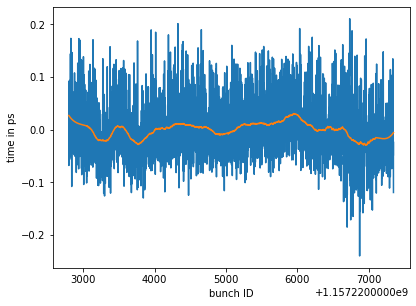

In [10]:
# BAM plots ala Stefan

BAMXTD_smooth=scipy.signal.savgol_filter(df["BAM - 8FL2XTDS mean"]-df["BAM - 8FL2XTDS mean"].mean(), 501, 3)
BAMXTD=(df["BAM - 8FL2XTDS mean"]-df["BAM - 8FL2XTDS mean"].mean())
plt.plot(df["BAM - 8FL2XTDS mean"]-df["BAM - 8FL2XTDS mean"].mean())
plt.plot(bunchID,BAMXTD_smooth) # window size 500, polynomial order 3
plt.xlabel('bunch ID')
plt.ylabel('time in ps')
plt.show()

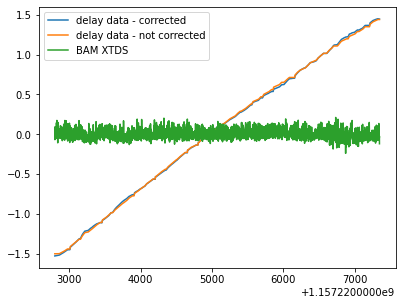

In [16]:
plt.plot(bunchID,delay[0:len(adc_no_bck[1,:])]-BAMXTD_smooth,label="delay data - corrected")
plt.plot(bunchID,delay[0:len(adc_no_bck[1,:])],label="delay data - not corrected")
plt.plot(bunchID,BAMXTD,label="BAM XTDS")
plt.legend()


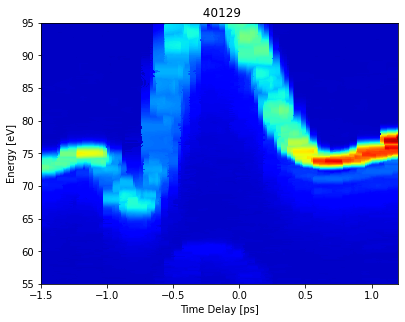

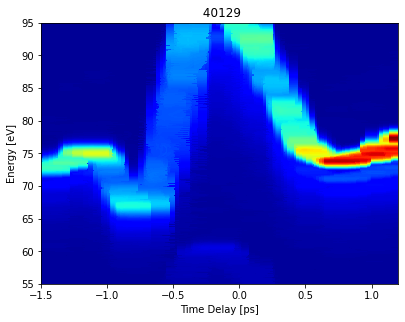

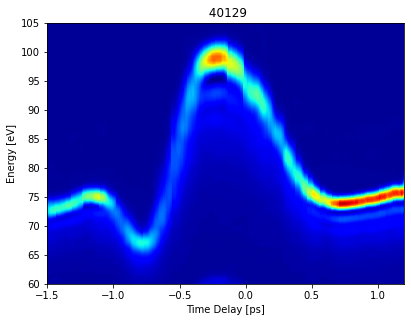

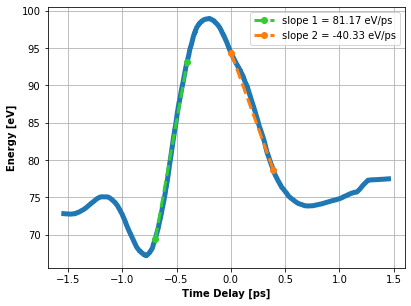

shift 15.90226929846326
Amax:: 3.1158730748751164e-06
V potential:: 3.1158730748751164e-06 0.0 3.1158730748751164e-06


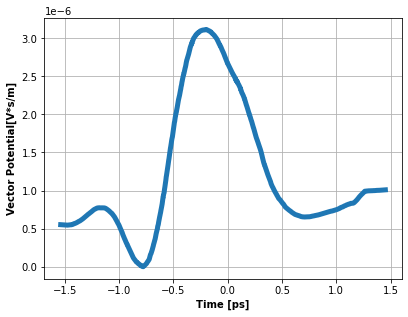

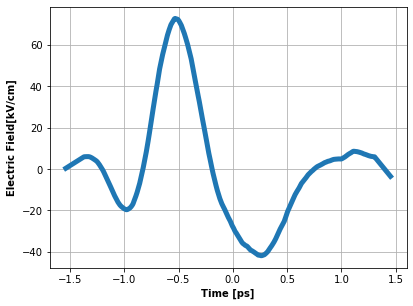

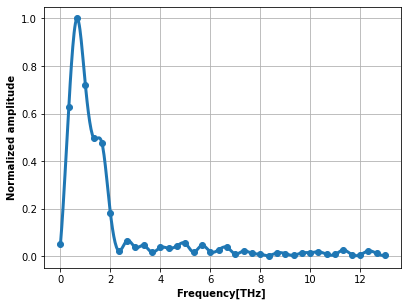

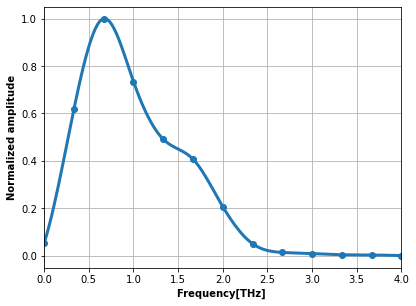

In [17]:

#delay[0:len(adc_data1)]
XX, Y = np.meshgrid(delay[0:len(adc_no_bck[1,:])]-BAMXTD, energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
ax.set_xlabel('Time Delay [ps]')
ax.set_ylabel('Energy [eV]')
plt.title(' %s' % run_number)
ax.tick_params()
CS = ax.contourf(XX, Y, ((savgol_filter(adc_no_bck, 15, 1))), 500, cmap=plt.cm.jet) #vmax=700, vmin=-1800)
plt.ylim(55,95)
plt.xlim(-1.5,1.2)
#plt.savefig(f"{run_number}_trace.png",dpi=300)
#plt.savefig("trace_TOF1.svg", format="svg")
plt.show()

#################################################################

#delay[0:len(adc_data1)]
XX, Y = np.meshgrid(delay[0:len(adc_no_bck[1,:])]+BAMXTD, energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
ax.set_xlabel('Time Delay [ps]')
ax.set_ylabel('Energy [eV]')
plt.title(' %s' % run_number)
ax.tick_params()
CS = ax.contourf(XX, Y, ((savgol_filter(adc_no_bck, 105, 1))), 500, cmap=plt.cm.jet) #vmax=700, vmin=-1800)
plt.ylim(55,95)
plt.xlim(-1.5,1.2)
#plt.savefig(f"{run_number}_trace.png",dpi=300)
#plt.savefig("trace_TOF1.svg", format="svg")
plt.show()

#################################################################

XX, Y = np.meshgrid(delay[0:len(adc_no_bck[1,:])], energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
ax.set_xlabel('Time Delay [ps]')
ax.set_ylabel('Energy [eV]')
plt.title(' %s' % run_number)
ax.tick_params()
CS = ax.contourf(XX, Y, (remove_bckg(savgol_filter(adc_no_bck, 105, 1))), 500, cmap=plt.cm.jet) #vmax=700, vmin=-1800)
plt.ylim(60,105)
plt.xlim(-1.5,1.2)
#plt.savefig(f"{run_number}_trace.png",dpi=300)
#plt.savefig("trace_TOF1.svg", format="svg")
plt.show()

#################################################################

Str_trace = get_pulses_peak_energy_value(delay[0:len(adc_data1)], energy_axis, adc_no_bck)

smooth_trace = savgol_filter(Str_trace, 175, 1)

plt.plot(savgol_filter(delay[0:len(adc_data1)],401,1),smooth_trace,linewidth=5.0)
plt.xlabel('Time Delay [ps]', fontweight='bold')
plt.ylabel('Energy [eV]',fontweight='bold')

p1,p2,slope1 = sloper(-0.55,savgol_filter(delay[0:len(adc_data1)],401,1), smooth_trace,200)
p3,p4,slope2 = sloper(0.2,savgol_filter(delay[0:len(adc_data1)],401,1), smooth_trace,300)

plt.plot(p1,p2,'o--',label=('slope 1 = %s eV/ps' % round((slope1),2)),linewidth=3.0,color='limegreen')
plt.plot(p3,p4,'o--',label=('slope 2 = %s eV/ps' % round((slope2),2)),linewidth=3.0)
plt.legend()

plt.grid()
#plt.savefig(f"{run_number}_max_trace.png")
plt.show()

#################################################################

vec_poten = streaking_to_vector_potential_units(smooth_trace, w_0)

plt.plot(savgol_filter(delay[0:len(adc_data1)],401,1),vec_poten,linewidth=5.0)
plt.xlabel('Time [ps]', fontweight='bold')
plt.ylabel('Vector Potential[V*s/m]', fontweight='bold')
plt.grid()
#plt.savefig(f"{run_number}_vector.png")
plt.show()

#################################################################

elec_field = np.gradient(vec_poten, savgol_filter(delay[0:len(adc_data1)],401,1)*1E-12) # calculating the electric field from the vector potential
smoothed_elec_field = savgol_filter(elec_field, 19, 1)
elec_field_kv_cm = smoothed_elec_field*1e-5

plt.xlabel('Time [ps]',  fontweight='bold')
plt.ylabel('Electric Field[kV/cm]', fontweight='bold')
#plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 1))
plt.plot(savgol_filter(delay[0:len(adc_data1)],401,1), savgol_filter(elec_field_kv_cm,531,1) ,linewidth=5.0)

#plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
#plt.savefig(f"{run_number}_Efield.png")
plt.show()

#################################################################

spectrum = np.fft.fft(elec_field_kv_cm)

plt.xlabel('Frequency[THz] ',fontweight='bold')
plt.ylabel('Normalized amplitude', fontweight='bold')
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)), 'o',linewidth=5.0)

x = frequency[:int(len(frequency)/2.5)] # this line is to smoothen the curve
X_Y_Spline = make_interp_spline(frequency[:int(len(frequency)/2.5)],(np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)))
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

plt.plot(X_,Y_,'#1f77b4',linewidth=3.0)

# plt.savefig(path_save+'/plots/'+run_number+'_amplitude_thz'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'amplitude_thz'+'.png', dpi=600)
plt.grid()
plt.savefig(f"{run_number}_spect.png")
plt.show()

#################################################################

new_length = 1000 # length of interpolated array
new_time = np.linspace(time_averaged_step_size[0:len(e_field)].min(), time_averaged_step_size[0:len(e_field)].max(), new_length)
new_field = sp.interpolate.interp1d(time_averaged_step_size[0:len(e_field)], e_field, kind='cubic')(new_time)

window = signal.windows.tukey(len(new_field))

spectrum_new = signal.detrend(np.fft.fft(window*new_field[0:int(len(new_field))]))  #I have to apply a window on the e field 
spectrum_new = spectrum_new - np.mean(spectrum_new)
plt.xlabel('Frequency[THz] ',fontweight='bold')
plt.ylabel('Normalized amplitude', fontweight='bold')
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum_new)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum_new)), 'o',linewidth=5.0)

#x = frequency[:int(len(frequency)/2.5)] # this line is to smoothen the curve
new_Spline = make_interp_spline(frequency[:int(len(frequency)/2.5)],(np.absolute(spectrum_new)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum_new)))
x_ = np.linspace(x.min(), x.max(), 500)
y_ = new_Spline(x_)
plt.plot(x_,y_,'#1f77b4',linewidth=3.0)
plt.xlim(0,4)
#plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)), 'o',linewidth=5.0)
plt.grid()
#plt.savefig(f"{run_number}_spectrum_windowed.png")
plt.show()


### to smooth the electric field

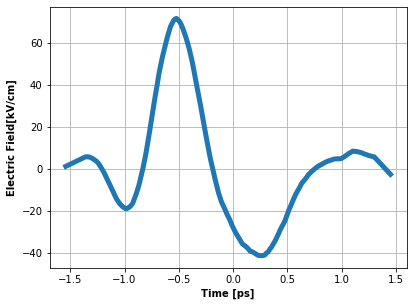

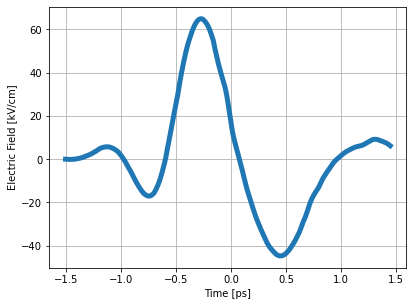

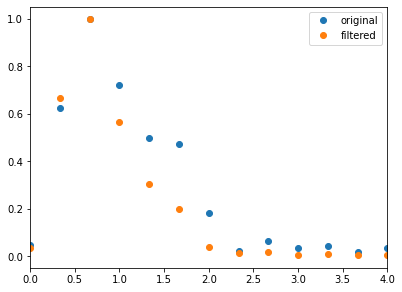

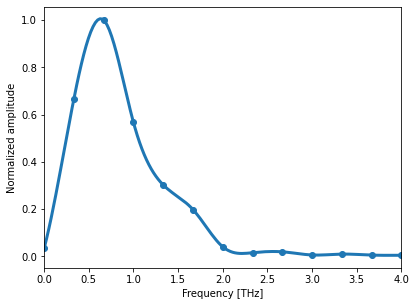

In [18]:
import scipy.fftpack

elec_field = np.gradient(vec_poten, savgol_filter(delay[0:len(adc_data1)],401,1)*1E-12) # calculating the electric field from the vector potential
smoothed_elec_field = savgol_filter(elec_field, 19, 1)
elec_field_kv_cm = smoothed_elec_field*1e-5

plt.xlabel('Time [ps]',  fontweight='bold')
plt.ylabel('Electric Field[kV/cm]', fontweight='bold')
#plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 1))
plt.plot(savgol_filter(delay[0:len(adc_data1)],421,1), savgol_filter(elec_field_kv_cm,551,1),linewidth=5.0)

#plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
plt.show()

sos = signal.butter(2, 700, btype='low', fs=1000000, output='sos')
filtered = signal.sosfilt(sos, elec_field_kv_cm)
plt.plot(savgol_filter(delay[0:len(adc_data1)],121,1), savgol_filter(filtered,91,1) ,linewidth=5.0)

plt.grid()
plt.xlabel('Time [ps]')
plt.ylabel('Electric Field [kV/cm]')
plt.savefig("field_filtered_TOF2.svg", format="svg")
plt.show()



spectrum = np.fft.fft(elec_field_kv_cm)
spectrum1 = np.fft.fft(filtered)

plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)),"o",label="original")
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum1)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum1)),"o",label="filtered")
plt.legend()
plt.xlim(0,4)
plt.show()

x = frequency[:int(len(frequency)/2.5)]
neu_Spline = make_interp_spline(x,(np.absolute(spectrum1)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum1)))
x_ = np.linspace(x.min(), x.max(), 500)
y_ = neu_Spline(x_)
plt.plot(x_,y_,'#1f77b4',linewidth=3.0)
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum1)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum1)),"o",label="filtered")
plt.xlim(0,4)
plt.xlabel('Frequency [THz]')
plt.ylabel('Normalized amplitude')
plt.savefig("spec_filtered_TOF2.svg", format="svg")
plt.show()


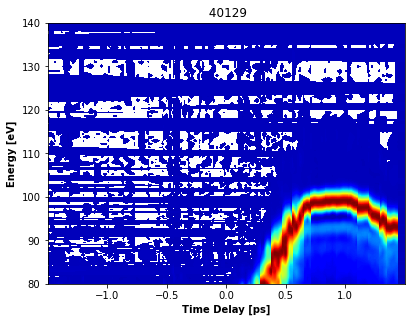

str trace is longer


ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [322]:

X, Y = np.meshgrid(laser_delay_data, energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
ax.set_xlabel('Time Delay [ps]', fontweight='bold')
ax.set_ylabel('Energy [eV]',fontweight='bold')
plt.title(' %s' % run_number)
ax.tick_params()
CS = ax.contourf(X, Y, normalize_matrix(trace_reduced[0:len(energy_axis),0:len(laser_delay_data)]), 500, cmap=plt.cm.jet) #vmax=700, vmin=-1800)
plt.ylim(80,140)
plt.show()
print("str trace is longer")



Str_trace = get_pulses_peak_energy_value(laser_delay_data, energy_axis, normalize_matrix(trace_reduced[0:len(energy_axis),0:len(laser_delay_data)]))

smooth_trace = savgol_filter(Str_trace, 175, 1)

plt.plot(savgol_filter(laser_delay_data,21,1),smooth_trace,linewidth=5.0)
plt.xlabel('Time Delay [ps]', fontweight='bold')
plt.ylabel('Energy [eV]',fontweight='bold')


p1,p2,slope1 = sloper(-0.8,savgol_filter(delay[0:len(adc_data1)],401,1), smooth_trace,100)
p3,p4,slope2 = sloper(-0.1,savgol_filter(delay[0:len(adc_data1)],401,1), smooth_trace,300)

plt.plot(p1,p2,'o--',label=('slope 1 = %s eV/ps' % round((slope1),2)),linewidth=3.0,color='limegreen')
plt.plot(p3,p4,'o--',label=('slope 2 = %s eV/ps' % round((slope2),2)),linewidth=3.0)
plt.legend()

plt.grid()
plt.savefig(f"{run_number}_max_trace.png")
plt.show()


vec_poten = streaking_to_vector_potential_units(smooth_trace, w_0)

plt.plot(savgol_filter(delay[0:len(adc_data1)],21,1),vec_poten,linewidth=5.0)
plt.xlabel('Time [ps]', fontweight='bold')
plt.ylabel('Vector Potential[V*s/m]', fontweight='bold')
plt.grid()
plt.savefig(f"{run_number}_vector.png")
plt.show()


elec_field = np.gradient(vec_poten, savgol_filter(delay[0:len(adc_data1)],401,1)*1E-12) # calculating the electric field from the vector potential
smoothed_elec_field = savgol_filter(elec_field, 19, 1)
elec_field_kv_cm = smoothed_elec_field*1e-5

plt.xlabel('Time [ps]',  fontweight='bold')
plt.ylabel('Electric Field[kV/cm]', fontweight='bold')
#plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 1))
plt.plot(savgol_filter(delay[0:len(adc_data1)],401,1), savgol_filter(elec_field_kv_cm,531,1) ,linewidth=5.0)

#plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
plt.savefig(f"{run_number}_Efield.png")
plt.show()


spectrum = np.fft.fft(elec_field_kv_cm)


plt.xlabel('Frequency[THz] ',fontweight='bold')
plt.ylabel('Normalized amplitude', fontweight='bold')
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)), 'o',linewidth=5.0)

x = frequency[:int(len(frequency)/2.5)] # this line is to smoothen the curve
X_Y_Spline = make_interp_spline(frequency[:int(len(frequency)/2.5)],(np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)))
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

plt.plot(X_,Y_,'#1f77b4',linewidth=3.0)

# plt.savefig(path_save+'/plots/'+run_number+'_amplitude_thz'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'amplitude_thz'+'.png', dpi=600)
plt.grid()
plt.savefig(f"{run_number}_spect.png")
plt.show()


new_length = 1000 # length of interpolated array
new_time = np.linspace(time_averaged_step_size[0:len(e_field)].min(), time_averaged_step_size[0:len(e_field)].max(), new_length)
new_field = sp.interpolate.interp1d(time_averaged_step_size[0:len(e_field)], e_field, kind='cubic')(new_time)


window = signal.windows.tukey(len(new_field))


spectrum_new = signal.detrend(np.fft.fft(window*new_field[0:int(len(new_field))]))  #I have to apply a window on the e field 
spectrum_new = spectrum_new - np.mean(spectrum_new)
plt.xlabel('Frequency[THz] ',fontweight='bold')
plt.ylabel('Normalized amplitude', fontweight='bold')
plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum_new)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum_new)), 'o',linewidth=5.0)

#x = frequency[:int(len(frequency)/2.5)] # this line is to smoothen the curve
new_Spline = make_interp_spline(frequency[:int(len(frequency)/2.5)],(np.absolute(spectrum_new)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum_new)))
x_ = np.linspace(x.min(), x.max(), 500)
y_ = new_Spline(x_)
plt.plot(x_,y_,'#1f77b4',linewidth=3.0)
plt.xlim(0,4)
#plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)), 'o',linewidth=5.0)
plt.grid()
plt.savefig(f"{run_number}_spectrum_windowed.png")
plt.show()


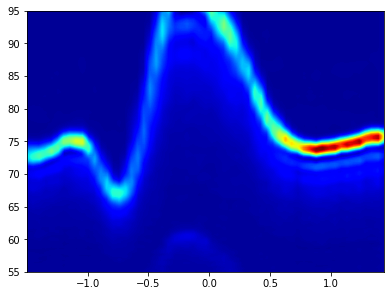

In [20]:
trace_reduced = block_reduce((savgol_filter(adc_no_bck[:,1:4100], 15, 1)), block_size=(1,70), func=np.sum, cval=np.mean(adc_no_bck[:,1:4100]))
new_time_axis = np.linspace(delay[0],delay[-1],len(trace_reduced[1]))

XX, Y = np.meshgrid(new_time_axis, energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
#ax.set_xlabel('Time Delay [ps]')
#ax.set_ylabel('Energy [eV]')
#plt.title(' %s' % run_number)
ax.tick_params()
CS = ax.contourf(XX, Y, trace_reduced, 500, cmap=plt.cm.jet) #vmax=700, vmin=-1800)
plt.ylim(55,95)
#plt.ylim(60,105)
#plt.xlim(-1.5,1.2)
plt.savefig("trace_TOF2_long.png", format="png")
plt.show()


In [21]:
new_size = 10
max_length = 4200
corrected_delay = np.array(delay[0:len(adc_no_bck[1,0:max_length])]-BAMXTD[0:len(adc_no_bck[1,0:max_length])])
corrected_delay2 = np.array(delay[0:len(adc_no_bck[1,0:max_length])]+BAMXTD[0:len(adc_no_bck[1,0:max_length])])
corrected_delay_shorten = corrected_delay.reshape(-1, new_size).mean(axis=1)
corrected_delay_shorten2 = corrected_delay2.reshape(-1, new_size).mean(axis=1)
trace_reduced = block_reduce((savgol_filter(adc_no_bck[:,0:max_length], 11, 1)), block_size=(1,new_size), func=np.sum, cval=np.sum(adc_no_bck[:,0:max_length]))

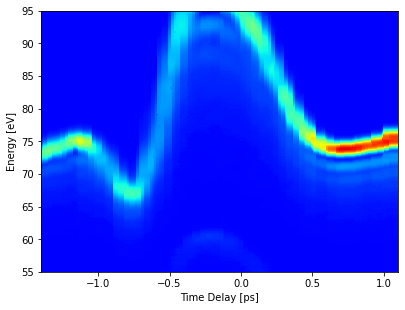

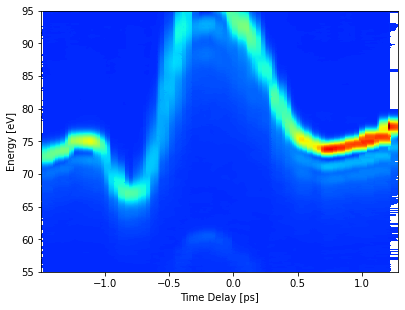

In [22]:
X, Y = np.meshgrid(corrected_delay_shorten, energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
ax.set_xlabel('Time Delay [ps]')
ax.set_ylabel('Energy [eV]')
ax.tick_params()
CS = ax.contourf(X, Y, ((savgol_filter(trace_reduced, 11, 1))), 600, cmap=plt.cm.jet)#, vmax=40000, vmin=-8000)
plt.ylim(55,95)
plt.xlim(-1.4,1.1)
plt.savefig("trace_TOF2.png", format="png")
plt.show()


X, Y = np.meshgrid(corrected_delay_shorten2, energy_axis)  
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w')
ax.set_xlabel('Time Delay [ps]')
ax.set_ylabel('Energy [eV]')
ax.tick_params()
CS = ax.contourf(X, Y, ((savgol_filter(trace_reduced, 13, 1))), 600, cmap=plt.cm.jet)#, vmax=40000, vmin=-8000)
plt.ylim(55,95)
#plt.xlim(-1.4,1.1)
plt.show() 

shift 16.11574696464301
Amax:: 3.1577016529008288e-06
V potential:: 3.1577016529008288e-06 0.0 3.1577016529008288e-06


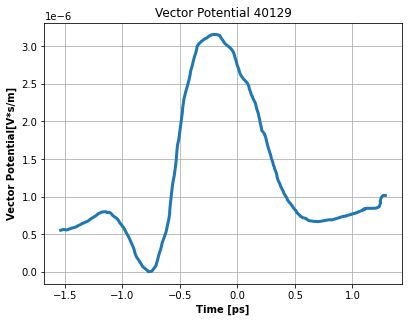

In [23]:
Streaking_Trace_eV_step_size = get_pulses_peak_energy_value(corrected_delay_shorten, energy_axis, ((savgol_filter(trace_reduced, 5, 1))))

smoothed_Streaking_Trace_eV_step_size = savgol_filter(Streaking_Trace_eV_step_size, 15, 3)
vector_potential = streaking_to_vector_potential_units(smoothed_Streaking_Trace_eV_step_size, w_0) # converting the streaking trace into vector potential function

plt.figure()
plt.xlabel('Time [ps]', fontweight='bold')
plt.ylabel('Vector Potential[V*s/m]', fontweight='bold')
plt.title('Vector Potential %s' % run_number)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 1))
plt.plot(savgol_filter(corrected_delay_shorten,11,1),savgol_filter(vector_potential,5,1),linewidth=3.0)
# plt.savefig(path_save+'/plots/'+run_number+'_vector_potential_evsm'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'vector_potential_evsm'+'.png', dpi=600)

plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
#plt.savefig(f"{run_number}_vector_potential.png")
plt.show()

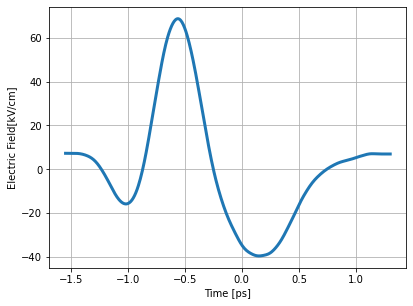

In [24]:
electric_field = np.gradient(savgol_filter(vector_potential,61,1), savgol_filter(corrected_delay_shorten,191,1)*1E-12) # calculating the electric field from the vector potential
smoothed_electric_field = savgol_filter(electric_field, 15, 3)
electric_field_kv_cm = smoothed_electric_field*1e-5


#plt.plot(savgol_filter(corrected_delay_shorten,11,1),savgol_filter(electric_field_kv_cm,11,1),"o")
#plt.show()

corrected_delay_shorten_new = np.linspace(np.min(corrected_delay_shorten),np.max(corrected_delay_shorten), len (corrected_delay_shorten))
x = corrected_delay_shorten_new
y = savgol_filter(electric_field_kv_cm,11,1)
neu_Spline = make_interp_spline(x,y, k=3, t=None, bc_type=None, axis=0, check_finite=True)
x_ = np.linspace(x.min(), x.max(), 500)
y_ = neu_Spline(x_)

################################################################# fourth plot - E-field #################################################################

plt.figure()   # shows the calculated electric field of the THz pulse
plt.xlabel('Time [ps]')
plt.ylabel('Electric Field[kV/cm]')
plt.xticks(np.arange(np.nanmin(time_averaged_step_size)-0.5, np.nanmax(time_averaged_step_size)+0.5, 1))
plt.plot(x_,savgol_filter(y_,31,1),linewidth=3.0)
# plt.savefig(path_save+'/plots/'+run_number+'_electric_field_kvcm'+auger+'.png')
# plt.savefig(path+'/processed'+'/plots/'+run_number+extra+'electric_field_kvcm'+'.png', dpi=600)
plt.xticks(np.arange(-1.5, 1.5, 0.5))
plt.grid()
plt.savefig(f"{run_number}_Efield_tof1.svg")
plt.show()

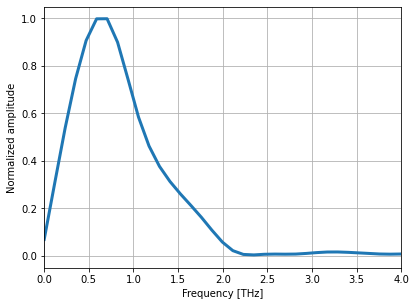

In [25]:
spectrum = np.fft.fft(electric_field_kv_cm)
frequency = np.fft.fftfreq(electric_field_kv_cm.size, np.nanmean(np.diff(corrected_delay_shorten_new)))

#plt.plot(frequency[:int(len(frequency)/2.5)], (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum)),"o",linewidth=5.0)
plt.xlim(0,4)

x = frequency[:int(len(frequency)/2.5)]
y = (np.absolute(spectrum)[:int(len(frequency)/2.5)])/np.max(np.absolute(spectrum))
neu_Spline = make_interp_spline(x,y, k=3, t=None, bc_type=None, axis=0, check_finite=True)
x_ = np.linspace(x.min(), x.max(), 500)
y_ = neu_Spline(x_)
plt.plot(x_,y_,linewidth=3.0)
plt.xlabel('Frequency [THz]')
plt.ylabel('Normalized amplitude')
plt.grid()
plt.savefig("spec_filtered_TOF1.svg", format="svg")
plt.show()